In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
from enum import Enum
import random
import math
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

In [3]:
class SchedulingPolicy(Enum):
    RM = "Rate Monotonic"     
    EDF = "Earliest Deadline First"  
    FIFO = "First In First Out"     

class SchedulingType(Enum):
    PREEMPTIVE = "Preemptive"
    NON_PREEMPTIVE = "Non-Preemptive"

class SchedulingModel(Enum):
    PARTITIONED = "Partitioned"  
    GLOBAL = "Global"           

In [4]:
@dataclass
class Task:
    id: int
    period: float
    net: float  
    deadline: float
    priority: int
    arrival_time: float = 0.0
    core_id: int = 0

In [5]:
class RealTimeSystem:
    def __init__(self, num_cores: int = 4, scheduling_policy: SchedulingPolicy = SchedulingPolicy.RM,
                 scheduling_type: SchedulingType = SchedulingType.PREEMPTIVE,
                 scheduling_model: SchedulingModel = SchedulingModel.PARTITIONED):
        self.num_cores = num_cores
        self.scheduling_policy = scheduling_policy
        self.scheduling_type = scheduling_type
        self.scheduling_model = scheduling_model
        self.tasks: List[Task] = []
        self.analysis_results = {}
        self.core_assignments: Dict[int, List[int]] = {i: [] for i in range(num_cores)}
        
    def generate_task_set(self, num_tasks: int, target_utilization: float, 
                         period_range: Tuple[int, int] = (10, 100)) -> List[Task]:
        tasks = []
        utilizations = self._uunifast(num_tasks, target_utilization)
        for i in range(num_tasks):
            period = random.randint(period_range[0], period_range[1])
            net = utilizations[i] * period
            deadline = period
            
            if self.scheduling_policy == SchedulingPolicy.RM:
                priority = period  
            elif self.scheduling_policy == SchedulingPolicy.EDF:
                priority = deadline 
            else:  # FIFO
                priority = i  
            
            task = Task(
                id=i,
                period=period,
                net=net,
                deadline=deadline,
                priority=priority,
                arrival_time=0.0
            )
            tasks.append(task)
        
        tasks.sort(key=lambda t: t.priority)
        
        if self.scheduling_model == SchedulingModel.PARTITIONED:
            self._assign_tasks_to_cores_partitioned(tasks)
        
        self.tasks = tasks
        return tasks
    
    def _assign_tasks_to_cores_partitioned(self, tasks: List[Task]) -> None:
        self.core_assignments = {i: [] for i in range(self.num_cores)}
        core_utilizations = [0.0] * self.num_cores
        
        tasks_by_util = sorted(tasks, key=lambda t: t.net/t.period, reverse=True)
        
        for task in tasks_by_util:
            task_utilization = task.net / task.period
            
            best_core = 0
            max_remaining_capacity = 1.0 - core_utilizations[0]
            
            for core_id in range(1, self.num_cores):
                remaining_capacity = 1.0 - core_utilizations[core_id]
                if remaining_capacity > max_remaining_capacity:
                    max_remaining_capacity = remaining_capacity
                    best_core = core_id
            
            if core_utilizations[best_core] + task_utilization <= 1.0:
                task.core_id = best_core
                self.core_assignments[best_core].append(task.id)
                core_utilizations[best_core] += task_utilization
            else:
                min_util_core = core_utilizations.index(min(core_utilizations))
                task.core_id = min_util_core
                self.core_assignments[min_util_core].append(task.id)
                core_utilizations[min_util_core] += task_utilization
    
    def _uunifast(self, n: int, target_u: float) -> List[float]:
        if n == 1:
            return [target_u]
        
        utilizations = []
        sum_u = target_u
        
        for i in range(n - 1):
            next_sum_u = sum_u * (random.random() ** (1.0 / (n - i)))
            utilizations.append(sum_u - next_sum_u)
            sum_u = next_sum_u
        
        utilizations.append(sum_u)
        return utilizations
    
    def calculate_response_time_with_overrun(self, task_index: int, overrun_amount: float) -> float:
        if task_index >= len(self.tasks):
            return float('inf')
        
        task = self.tasks[task_index]
        
        if self.scheduling_model == SchedulingModel.PARTITIONED:
            return self._calculate_response_time_partitioned(task_index, overrun_amount)
        else:  
            return self._calculate_response_time_global(task_index, overrun_amount)
    
    def _calculate_response_time_partitioned(self, task_index: int, overrun_amount: float) -> float:
        task = self.tasks[task_index]
        same_core_tasks = [t for t in self.tasks if t.core_id == task.core_id]
        same_core_tasks.sort(key=lambda t: t.priority)
        task_pos = next(i for i, t in enumerate(same_core_tasks) if t.id == task.id)
        R = task.net + overrun_amount
        R_prev = 0
        max_iterations = 100
        iteration = 0
        
        while abs(R - R_prev) > 0.001 and iteration < max_iterations:
            R_prev = R
            interference = 0
            for j in range(task_pos):  
                higher_priority_task = same_core_tasks[j]
                
                if self.scheduling_policy == SchedulingPolicy.RM:
                    num_preemptions = math.ceil(R / higher_priority_task.period)
                    task_execution = higher_priority_task.net + (overrun_amount * 0.1)
                    interference += num_preemptions * task_execution
                
                elif self.scheduling_policy == SchedulingPolicy.EDF:
                    if higher_priority_task.deadline <= task.deadline:
                        num_preemptions = math.ceil(R / higher_priority_task.period)
                        interference += num_preemptions * higher_priority_task.net
                
                elif self.scheduling_policy == SchedulingPolicy.FIFO:
                    if higher_priority_task.arrival_time <= task.arrival_time:
                        interference += higher_priority_task.net
            
            R = task.net + overrun_amount + interference
            
            if R > task.deadline:
                return float('inf')
            iteration += 1
        return R
    
    def _calculate_response_time_global(self, task_index: int, overrun_amount: float) -> float:
        task = self.tasks[task_index]
        R = task.net + overrun_amount
        R_prev = 0
        max_iterations = 100
        iteration = 0
        
        while abs(R - R_prev) > 0.001 and iteration < max_iterations:
            R_prev = R
            total_interference = 0
            higher_priority_workload = 0
            for j in range(task_index): 
                higher_priority_task = self.tasks[j]
                
                if self.scheduling_policy == SchedulingPolicy.RM:
                    if higher_priority_task.period < task.period:
                        workload = math.ceil(R / higher_priority_task.period) * higher_priority_task.net
                        higher_priority_workload += workload
                
                elif self.scheduling_policy == SchedulingPolicy.EDF:
                    if higher_priority_task.deadline <= task.deadline:
                        workload = math.ceil(R / higher_priority_task.period) * higher_priority_task.net
                        higher_priority_workload += workload
                
                elif self.scheduling_policy == SchedulingPolicy.FIFO:
                    if higher_priority_task.arrival_time <= task.arrival_time:
                        higher_priority_workload += higher_priority_task.net
            
            max_parallel_interference = max(0, higher_priority_workload - (self.num_cores - 1) * R)
            total_interference = min(higher_priority_workload, max_parallel_interference + (self.num_cores - 1) * R)
            
            overrun_interference = overrun_amount * 0.2 * (task_index + 1) / len(self.tasks)
            total_interference += overrun_interference
            
            R = task.net + overrun_amount + total_interference / self.num_cores
            if R > task.deadline:
                return float('inf')
            iteration += 1
        return R
    
    def find_critical_overrun_values(self, task_index: int, max_overrun: float = 10.0, 
                                   step_size: float = 0.1) -> List[Tuple[float, float]]:
        critical_points = []
        overrun_values = np.arange(0, max_overrun, step_size)
        response_times = []
        
        for e in overrun_values:
            rt = self.calculate_response_time_with_overrun(task_index, e)
            response_times.append(rt)
        
        for i in range(1, len(response_times) - 1):
            if response_times[i] != float('inf'):
                if i > 0 and response_times[i-1] != float('inf'):
                    rate_of_change = (response_times[i] - response_times[i-1]) / step_size
                    
                    if rate_of_change > 2.0:  
                        critical_points.append((overrun_values[i], response_times[i]))
        
        return critical_points
    
    def analyze_system_performance(self, num_tasks_list: List[int], 
                                 utilization_rates: List[float]) -> Dict:
        results = {
            'configurations': [],
            'response_times': [],
            'critical_points': [],
            'schedulability': [],
            'performance_metrics': {},
            'scheduling_model_comparison': {}
        }
        
        print("Starting comprehensive system performance analysis...")
        print(f"Scheduling Policy: {self.scheduling_policy.value}")
        print(f"Scheduling Type: {self.scheduling_type.value}")
        print(f"Scheduling Model: {self.scheduling_model.value}")
        print(f"Number of Cores: {self.num_cores}")
        print("-" * 60)
        
        for num_tasks in num_tasks_list:
            for util_rate in utilization_rates:
                print(f"Analyzing: {num_tasks} tasks, utilization = {util_rate:.2f}")
                
                tasks = self.generate_task_set(num_tasks, util_rate)
                
                config_results = {
                    'num_tasks': num_tasks,
                    'utilization': util_rate,
                    'scheduling_model': self.scheduling_model.value,
                    'task_analysis': [],
                    'system_schedulable': True,
                    'avg_response_time': 0,
                    'max_response_time': 0,
                    'core_assignments': dict(self.core_assignments) if self.scheduling_model == SchedulingModel.PARTITIONED else None,
                    'migration_overhead': 0 if self.scheduling_model == SchedulingModel.PARTITIONED else self._estimate_migration_overhead(num_tasks)
                }
                
                total_response_time = 0
                max_response_time = 0
                
                for task_idx, task in enumerate(tasks):
                    baseline_rt = self.calculate_response_time_with_overrun(task_idx, 0.0)
                    critical_points = self.find_critical_overrun_values(task_idx, max_overrun=5.0)
                    moderate_overrun_rt = self.calculate_response_time_with_overrun(task_idx, 1.0)
        
                    task_analysis = {
                        'task_id': task.id,
                        'period': task.period,
                        'net': task.net,
                        'deadline': task.deadline,
                        'baseline_response_time': baseline_rt,
                        'moderate_overrun_response_time': moderate_overrun_rt,
                        'critical_points': len(critical_points),
                        'schedulable': baseline_rt <= task.deadline
                    }
                    
                    config_results['task_analysis'].append(task_analysis)
                    if baseline_rt == float('inf') or baseline_rt > task.deadline:
                        config_results['system_schedulable'] = False
                    if baseline_rt != float('inf'):
                        total_response_time += baseline_rt
                        max_response_time = max(max_response_time, baseline_rt)
                
                if config_results['system_schedulable']:
                    config_results['avg_response_time'] = total_response_time / num_tasks
                    config_results['max_response_time'] = max_response_time
    
                results['configurations'].append(config_results)
                print(f"  - Schedulable: {config_results['system_schedulable']}")
                if config_results['system_schedulable']:
                    print(f"  - Avg Response Time: {config_results['avg_response_time']:.2f}")
                    print(f"  - Max Response Time: {config_results['max_response_time']:.2f}")
                print()
        
        self.analysis_results = results
        return results
    
    def _estimate_migration_overhead(self, num_tasks: int) -> float:
        base_overhead = 0.05  
        complexity_factor = min(num_tasks / 100.0, 1.0)  
        return base_overhead * (1 + complexity_factor)
    
    def compare_scheduling_models(self, num_tasks_list: List[int], 
                                utilization_rates: List[float]) -> Dict:
        comparison_results = {
            'partitioned_results': {},
            'global_results': {},
            'performance_comparison': {}
        }
        
        print("\nComparing Partitioned vs Global Scheduling Models")
        print("=" * 60)
        
        original_model = self.scheduling_model
        
        print("Testing Partitioned Scheduling...")
        self.scheduling_model = SchedulingModel.PARTITIONED
        partitioned_results = self.analyze_system_performance(num_tasks_list, utilization_rates)
        comparison_results['partitioned_results'] = partitioned_results
        
        print("\nTesting Global Scheduling...")
        self.scheduling_model = SchedulingModel.GLOBAL
        global_results = self.analyze_system_performance(num_tasks_list, utilization_rates)
        comparison_results['global_results'] = global_results
        
        comparison_metrics = self._generate_comparison_metrics(partitioned_results, global_results)
        comparison_results['performance_comparison'] = comparison_metrics
        
        self.scheduling_model = original_model
        
        return comparison_results
    
    def _generate_comparison_metrics(self, partitioned_results: Dict, global_results: Dict) -> Dict:
        metrics = {
            'schedulability_comparison': {},
            'response_time_comparison': {},
            'scalability_analysis': {}
        }
        
        part_schedulable = sum(1 for config in partitioned_results['configurations'] 
                              if config['system_schedulable'])
        global_schedulable = sum(1 for config in global_results['configurations'] 
                                if config['system_schedulable'])
        
        total_configs = len(partitioned_results['configurations'])
        
        metrics['schedulability_comparison'] = {
            'partitioned_rate': part_schedulable / total_configs if total_configs > 0 else 0,
            'global_rate': global_schedulable / total_configs if total_configs > 0 else 0,
            'advantage': 'Global' if global_schedulable > part_schedulable else 'Partitioned'
        }
        
        part_avg_rt = []
        global_avg_rt = []
        
        for part_config, global_config in zip(partitioned_results['configurations'], 
                                            global_results['configurations']):
            if part_config['system_schedulable']:
                part_avg_rt.append(part_config['avg_response_time'])
            if global_config['system_schedulable']:
                global_avg_rt.append(global_config['avg_response_time'])
        
        if part_avg_rt and global_avg_rt:
            metrics['response_time_comparison'] = {
                'partitioned_avg': np.mean(part_avg_rt),
                'global_avg': np.mean(global_avg_rt),
                'improvement': (np.mean(part_avg_rt) - np.mean(global_avg_rt)) / np.mean(part_avg_rt) * 100
            }
        
        return metrics
    
    def generate_performance_graphs(self, results: Dict) -> None:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Graph 1: Average Response Time vs Number of Tasks
        utilization_rates = [0.25, 0.5, 0.75]
        colors = ['blue', 'green', 'red']
        
        for i, util_rate in enumerate(utilization_rates):
            task_counts = []
            avg_response_times = []
            
            for config in results['configurations']:
                if config['utilization'] == util_rate and config['system_schedulable']:
                    task_counts.append(config['num_tasks'])
                    avg_response_times.append(config['avg_response_time'])
            
            if task_counts:  # Only plot if we have data
                ax1.plot(task_counts, avg_response_times, 
                        marker='o', color=colors[i], label=f'Utilization = {util_rate}')
        
        ax1.set_xlabel('Number of Tasks')
        ax1.set_ylabel('Average Response Time')
        ax1.set_title('Average Response Time vs Number of Tasks')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Graph 2: Maximum Response Time vs Number of Tasks
        for i, util_rate in enumerate(utilization_rates):
            task_counts = []
            max_response_times = []
            
            for config in results['configurations']:
                if config['utilization'] == util_rate and config['system_schedulable']:
                    task_counts.append(config['num_tasks'])
                    max_response_times.append(config['max_response_time'])
            
            if task_counts:
                ax2.plot(task_counts, max_response_times, 
                        marker='s', color=colors[i], label=f'Utilization = {util_rate}')
        
        ax2.set_xlabel('Number of Tasks')
        ax2.set_ylabel('Maximum Response Time')
        ax2.set_title('Maximum Response Time vs Number of Tasks')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Graph 3: Schedulability Analysis
        task_numbers = [10, 50, 100, 200, 400, 500]
        schedulability_matrix = np.zeros((len(utilization_rates), len(task_numbers)))
        
        for i, util_rate in enumerate(utilization_rates):
            for j, num_tasks in enumerate(task_numbers):
                for config in results['configurations']:
                    if (config['utilization'] == util_rate and 
                        config['num_tasks'] == num_tasks):
                        schedulability_matrix[i, j] = 1 if config['system_schedulable'] else 0
                        break
        
        im = ax3.imshow(schedulability_matrix, cmap='RdYlGn', aspect='auto')
        ax3.set_xticks(range(len(task_numbers)))
        ax3.set_xticklabels(task_numbers)
        ax3.set_yticks(range(len(utilization_rates)))
        ax3.set_yticklabels(utilization_rates)
        ax3.set_xlabel('Number of Tasks')
        ax3.set_ylabel('Utilization Rate')
        ax3.set_title('System Schedulability Matrix\n(Green=Schedulable, Red=Not Schedulable)')
        
        for i in range(len(utilization_rates)):
            for j in range(len(task_numbers)):
                text = 'Yes' if schedulability_matrix[i, j] == 1 else 'No'
                ax3.text(j, i, text, ha='center', va='center', color='black', fontweight='bold')
        
        # Graph 4: NET Overrun Impact (Example for one configuration)
        # Show response time vs overrun amount for a sample task
        if self.tasks:
            overrun_range = np.arange(0, 5, 0.1)
            sample_response_times = []
            
            for overrun in overrun_range:
                rt = self.calculate_response_time_with_overrun(0, overrun)
                if rt != float('inf'):
                    sample_response_times.append(rt)
                else:
                    sample_response_times.append(None)
            
            valid_overruns = []
            valid_response_times = []
            for i, rt in enumerate(sample_response_times):
                if rt is not None:
                    valid_overruns.append(overrun_range[i])
                    valid_response_times.append(rt)
            
            if valid_overruns:
                ax4.plot(valid_overruns, valid_response_times, 'b-', linewidth=2)
                ax4.axhline(y=self.tasks[0].deadline, color='r', linestyle='--', 
                           label=f'Deadline = {self.tasks[0].deadline:.1f}')
                ax4.set_xlabel('NET Overrun Amount (e)')
                ax4.set_ylabel('Response Time')
                ax4.set_title('Response Time vs NET Overrun\n(Sample Task)')
                ax4.legend()
                ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_detailed_results(self, results: Dict) -> None:
        print("\n" + "="*80)
        print("DETAILED REAL-TIME SYSTEM ANALYSIS RESULTS")
        print("="*80)
        
        print(f"System Configuration:")
        print(f"  - Scheduling Policy: {self.scheduling_policy.value}")
        print(f"  - Scheduling Type: {self.scheduling_type.value}")
        print(f"  - Scheduling Model: {self.scheduling_model.value}")
        print(f"  - Number of Cores: {self.num_cores}")
        print()
        
        # Summary statistics
        total_configs = len(results['configurations'])
        schedulable_configs = sum(1 for config in results['configurations'] 
                                if config['system_schedulable'])
        
        print(f"SUMMARY STATISTICS:")
        print(f"  - Total Configurations Tested: {total_configs}")
        print(f"  - Schedulable Configurations: {schedulable_configs}")
        print(f"  - Schedulability Rate: {(schedulable_configs/total_configs)*100:.1f}%")
        print()
        
        print("DETAILED RESULTS BY CONFIGURATION:")
        print("-" * 80)
        
        for config in results['configurations']:
            print(f"Configuration: {config['num_tasks']} tasks, "
                  f"utilization = {config['utilization']:.2f} "
                  f"({config.get('scheduling_model', 'Unknown')} Scheduling)")
            print(f"  Schedulable: {config['system_schedulable']}")
            
            if config['system_schedulable']:
                print(f"  Average Response Time: {config['avg_response_time']:.3f}")
                print(f"  Maximum Response Time: {config['max_response_time']:.3f}")
                
                if config.get('migration_overhead', 0) > 0:
                    print(f"  Migration Overhead: {config['migration_overhead']*100:.1f}%")
                
                if config.get('core_assignments'):
                    core_loads = []
                    for core_id, task_ids in config['core_assignments'].items():
                        core_loads.append(len(task_ids))
                    print(f"  Core Load Distribution: {core_loads}")
                
                critical_tasks = sum(1 for task in config['task_analysis'] 
                                   if task['critical_points'] > 0)
                print(f"  Tasks with Critical Overrun Points: {critical_tasks}")
            else:
                unschedulable_tasks = sum(1 for task in config['task_analysis'] 
                                        if not task['schedulable'])
                print(f"  Unschedulable Tasks: {unschedulable_tasks}")
            
            print()

Real-Time System NET Overrun Analysis
Starting comprehensive system performance analysis...
Scheduling Policy: Rate Monotonic
Scheduling Type: Preemptive
Scheduling Model: Partitioned
Number of Cores: 4
------------------------------------------------------------
Analyzing: 10 tasks, utilization = 0.25
  - Schedulable: True
  - Avg Response Time: 1.48
  - Max Response Time: 5.19

Analyzing: 10 tasks, utilization = 0.50
  - Schedulable: True
  - Avg Response Time: 4.42
  - Max Response Time: 14.07

Analyzing: 10 tasks, utilization = 0.75
  - Schedulable: True
  - Avg Response Time: 5.24
  - Max Response Time: 14.58

Analyzing: 50 tasks, utilization = 0.25
  - Schedulable: True
  - Avg Response Time: 1.32
  - Max Response Time: 4.20

Analyzing: 50 tasks, utilization = 0.50
  - Schedulable: True
  - Avg Response Time: 2.15
  - Max Response Time: 6.73

Analyzing: 50 tasks, utilization = 0.75
  - Schedulable: True
  - Avg Response Time: 3.78
  - Max Response Time: 12.33

Analyzing: 100 task

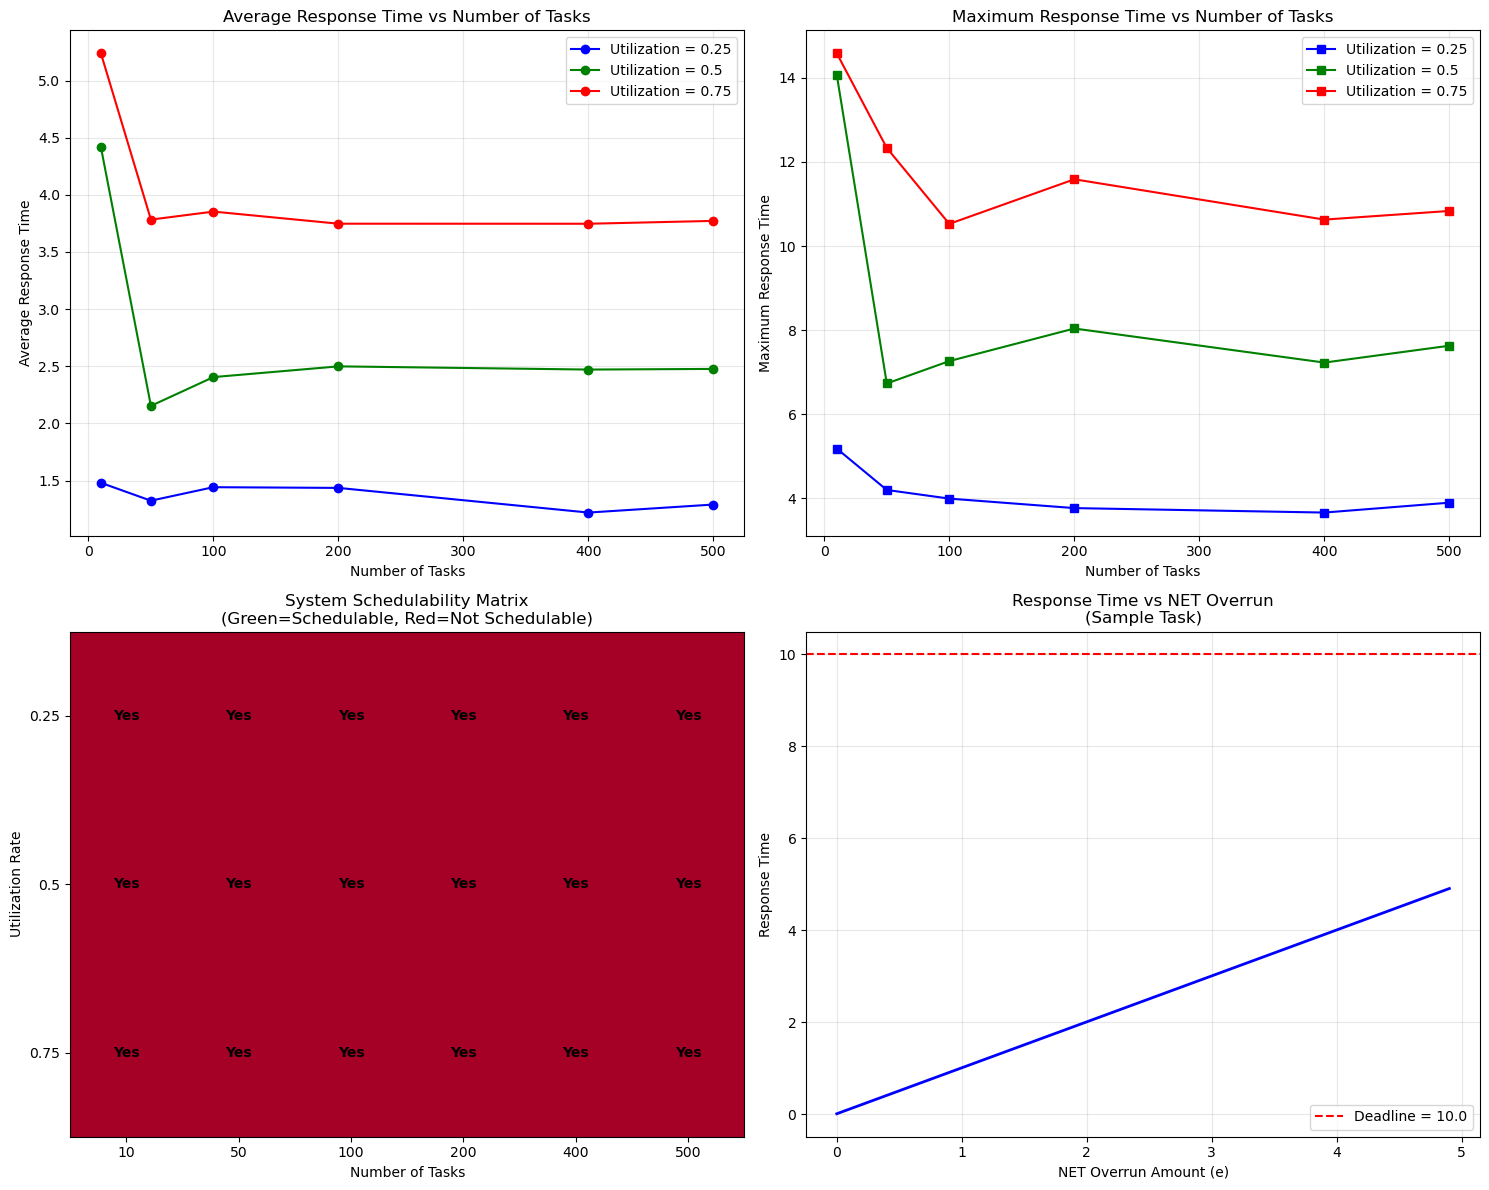


DETAILED REAL-TIME SYSTEM ANALYSIS RESULTS
System Configuration:
  - Scheduling Policy: Rate Monotonic
  - Scheduling Type: Preemptive
  - Scheduling Model: Partitioned
  - Number of Cores: 4

SUMMARY STATISTICS:
  - Total Configurations Tested: 18
  - Schedulable Configurations: 18
  - Schedulability Rate: 100.0%

DETAILED RESULTS BY CONFIGURATION:
--------------------------------------------------------------------------------
Configuration: 10 tasks, utilization = 0.25 (Partitioned Scheduling)
  Schedulable: True
  Average Response Time: 1.480
  Maximum Response Time: 5.186
  Core Load Distribution: [1, 1, 4, 4]
  Tasks with Critical Overrun Points: 0

Configuration: 10 tasks, utilization = 0.50 (Partitioned Scheduling)
  Schedulable: True
  Average Response Time: 4.417
  Maximum Response Time: 14.069
  Core Load Distribution: [1, 2, 3, 4]
  Tasks with Critical Overrun Points: 0

Configuration: 10 tasks, utilization = 0.75 (Partitioned Scheduling)
  Schedulable: True
  Average Resp

In [6]:
def main():
    print("Real-Time System NET Overrun Analysis")
    print("=" * 60)
    
    rt_system = RealTimeSystem(
        num_cores=4,
        scheduling_policy=SchedulingPolicy.RM,
        scheduling_type=SchedulingType.PREEMPTIVE
    )
    
    num_tasks_list = [10, 50, 100, 200, 400, 500]  
    utilization_rates = [0.25, 0.5, 0.75]          
    
    results = rt_system.analyze_system_performance(num_tasks_list, utilization_rates)
    
    rt_system.generate_performance_graphs(results)
    
    rt_system.print_detailed_results(results)
    
    print("\nCRITICAL OVERRUN ANALYSIS EXAMPLE:")
    print("-" * 40)
    
    if rt_system.tasks:
        for i in range(min(3, len(rt_system.tasks))):
            critical_points = rt_system.find_critical_overrun_values(i)
            print(f"Task {i+1} (Period: {rt_system.tasks[i].period:.1f}, "
                  f"NET: {rt_system.tasks[i].net:.3f}):")
            if critical_points:
                print(f"  Found {len(critical_points)} critical overrun points:")
                for overrun, response_time in critical_points[:3]:  # Show first 3
                    print(f"    Overrun = {overrun:.2f} -> Response Time = {response_time:.3f}")
            else:
                print(f"  No critical overrun points found in tested range")
            print()

if __name__ == "__main__":
    main()